In [3]:
# %pip install simple-icd-10 --quiet

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import simple_icd_10 as icd

In [25]:
df = pd.read_csv("bert_embeddings.tsv", sep="\t", index_col=0)

In [27]:
def str2np(s):
    return np.array([float(x) for x in map(
        lambda x: x.strip("[] \n"), 
        s.split(" ")
    ) if x != ''])

df["cls"] = df["cls"].apply(str2np)

In [28]:
df.head()

,icd10_category,description,cls
0,K76,Other diseases of liver,"[-0.291684359, 0.524830401, -0.618882298, -0.4..."
1,R18,Ascites,"[-0.425514311, 0.0404431485, -0.414673686, -0...."
2,K74,Fibrosis and cirrhosis of liver,"[-0.702546418, 0.163879544, -0.603203952, -0.5..."
3,B19,Unspecified viral hepatitis,"[-0.425079048, 0.0839554965, -0.700602233, -0...."
4,J44,Other chronic obstructive pulmonary disease,"[-0.459279835, 0.186151907, -0.658496559, -0.7..."


In [29]:
df["is_category"] = df["icd10_category"].apply(icd.is_category)
df = df[df["is_category"]]
df["parent"] = df["icd10_category"].apply(icd.get_parent)
df["chapter"] = df["parent"].apply(icd.get_parent)
df["is_chapter"] = df["chapter"].apply(icd.is_chapter)
df.loc[~df['is_chapter'], 'chapter'] = df.loc[~df['is_chapter'], 'chapter'].apply(icd.get_parent)
df["is_chapter"] = df["chapter"].apply(icd.is_chapter)
df.loc[~df['is_chapter'], 'chapter'] = df.loc[~df['is_chapter'], 'chapter'].apply(icd.get_parent)

In [30]:
df

,icd10_category,description,cls,is_category,parent,chapter,is_chapter
0,K76,Other diseases of liver,"[-0.291684359, 0.524830401, -0.618882298, -0.4...",True,K70-K77,XI,True
1,R18,Ascites,"[-0.425514311, 0.0404431485, -0.414673686, -0....",True,R10-R19,XVIII,True
2,K74,Fibrosis and cirrhosis of liver,"[-0.702546418, 0.163879544, -0.603203952, -0.5...",True,K70-K77,XI,True
3,B19,Unspecified viral hepatitis,"[-0.425079048, 0.0839554965, -0.700602233, -0....",True,B15-B19,I,True
4,J44,Other chronic obstructive pulmonary disease,"[-0.459279835, 0.186151907, -0.658496559, -0.7...",True,J40-J47,X,True
...,...,...,...,...,...,...,...
1691,W85,Exposure to electric transmission lines,"[0.0397250205, 0.411316991, -0.702246547, -0.5...",True,W85-W99,XX,False
1692,P07,Disorders related to short gestation and low b...,"[-0.321269006, -0.120399341, -0.808250129, -0....",True,P05-P08,XVI,True
1693,A27,Leptospirosis,"[-0.440600067, 0.297306091, -0.814109921, -0.6...",True,A20-A28,I,True
1694,Y64,Contaminated medical or biological substances,"[-0.0278060585, 0.658568382, -0.503495812, 0.1...",True,Y60-Y69,XX,True


In [31]:
df["description"] = df["chapter"].apply(icd.get_description)
df = df.sort_values(by='chapter')

/tmp/ipykernel_236991/3736254498.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


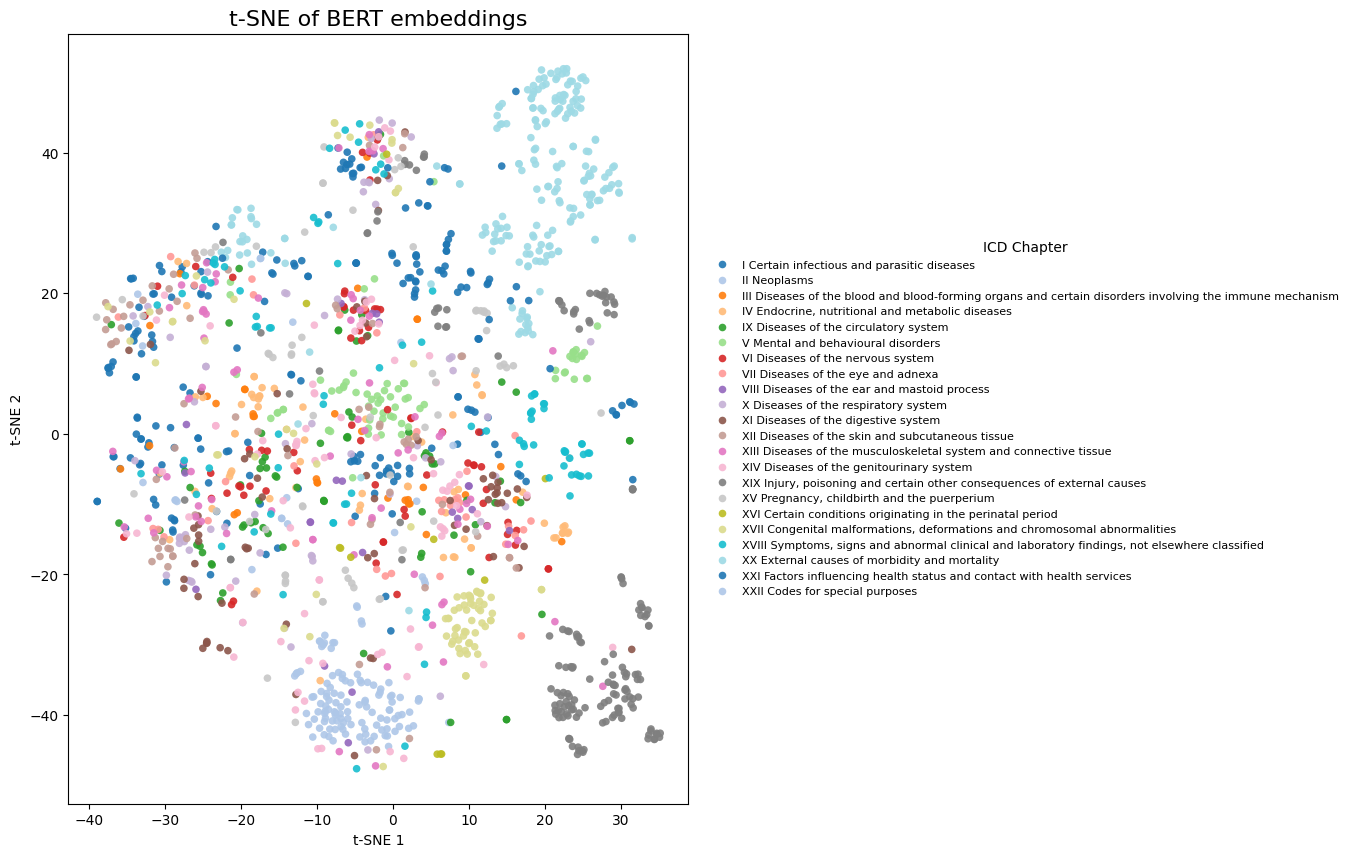

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

embeddings = np.vstack(df['cls'].values)

df['group'] = df['chapter'] + " " + df['description']

tsne = TSNE(n_components=2, random_state=42, perplexity=40)
tsne_results = tsne.fit_transform(embeddings)

df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]

plt.figure(figsize=(8, 10))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='group',
    palette='tab20',
    data=df,
    s=30,
    alpha=0.9,
    linewidth=0
)

plt.title("t-SNE of BERT embeddings", fontsize=16)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.legend(
    title="ICD Chapter",
    bbox_to_anchor=(1.02, 0.5), 
    loc='center left',  
    fontsize=8,
    title_fontsize='medium',
    ncol=1,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.savefig("pics/bert_tsne.png", dpi=100, bbox_inches='tight')
plt.show()